### 环境配置
 python version：3.8   
 modules：torch numpy pandas

### 调包

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch. optim as optim
import torch. nn. functional as F
import torch.utils.data as Data
import pandas as pd
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

d:\MySoftware\anaconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 自定义类和函数

In [535]:
class MyDataset(Data.Dataset):
    def __init__(self,x_train,y_train):
        self.x_train=torch.Tensor(x_train)
        self.y_train=torch.LongTensor(y_train)

    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

    def __len__(self):
        return len(self.y_train)


# 定义基本的fc、bn、激活层打包
class fbaBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(fbaBlock, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.fc(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class MyModel(nn.Module):
    def __init__(self,input_channels,n1,n2,n3,output_channels) -> None:
        super(MyModel,self).__init__()
        self.fba1 = fbaBlock(input_channels,n1)
        self.fba2 = fbaBlock(n1,n2)
        self.fba3 = fbaBlock(n2,n3)
        self.soft = nn.Softmax(dim=1)
        self.fc_end=nn.Linear(n3,output_channels)
    

    def forward(self,x):
        out=self.fba1(x)
        out=self.fba2(out)
        out=self.fba3(out)
        out=self.soft(out)
        out=self.fc_end(out)
        return out

class RNN(nn.Module):
    def __init__(self, input_channels,n1, hidden_size, rnn_num_layers, output_channels):
        super(RNN, self).__init__()
        self.fba1 = fbaBlock(input_channels,n1)
        self.hidden_size = hidden_size
        self.rnn_num_layers = rnn_num_layers
        self.rnn = nn.RNN(n1, hidden_size, rnn_num_layers, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_channels)
        # 对RNN层的权重进行初始化
        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_normal_(param)
            elif 'weight_hh' in name:
                nn.init.xavier_normal_(param)

    def forward(self, x):
        out = self.fba1(x)
        out = out.unsqueeze(1)
        h0 = torch.zeros(self.rnn_num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(out, h0)
        out = self.fc2(out[:, -1, :])
        return out

class BalancedSoftmaxLoss(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.weight = weight
    
    def forward(self, logits, labels):
        # print(logits.dtype,labels.dtype,self.weight.float().dtype)
        loss = F.cross_entropy(logits, labels, weight=self.weight.float())
        return loss

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = loss
            self.counter = 0

def BuildXY(Corn_name,x_length):
    '''
    Corn_name       数据集源自哪个币种      BNB BTC ETH
    x_length        样本序列长度            100 ……
    y_class_num     标签的数量              3 5 ……
    '''
    #-------------------读取文件
    market_data=pd.read_hdf('../cache/'+Corn_name+'_Trade.hdf', 'data')
    user_data=pd.read_excel('../cache/'+'交易结果表单3.xlsx')
    #---------------------------

    #-------------------市场数据降采样
    market_data['time']=market_data['time'].astype('str').str.slice(0,10).astype('int64')  ## 市场数据时间戳调整为10位
    market_data=market_data.drop_duplicates(subset=['time'],keep='first')  ## 去除市场数据时间戳重复
    #---------------------------

    #-------------------用户数据降采样到秒，同时生成时间戳字段
    user_data=user_data[user_data.currency==Corn_name]
    user_data=user_data.groupby(['start time'])
    user_data=user_data.apply(lambda x: 1 if 1 in x['hedge'].values else 0 ) 
    user_data=user_data.to_frame().reset_index()                    ## 将时间字段退索引
    user_data.columns = ['time', 'labels']
    user_data['time']=(pd.to_datetime(user_data['time']).astype('int64')//1e9).astype('int64')  ## 时间转化为时间戳
    #----------------------------
    
    #-------------------两块数据拼接并获得XY的来源序列
    merged_df=pd.merge(user_data, market_data, on='time', how='right')[['bid1_price','labels']]   ## 按时间戳匹配数据
    start=merged_df['labels'].first_valid_index()     ## 用户策略的第一个时刻
    end=merged_df['labels'].last_valid_index()     ## 用户策略的最后一个时刻
    merged_df=merged_df.iloc[start:end+1]    ## 截取用户进行过策略的片段
    merged_df.fillna(0,inplace=True)    ## 将没有操作的时间点NaN赋0
    #----------------------------

    #--------------------处理获得XY
    nplist=merged_df.to_numpy().T    ## 转numpy处理
    v = np.lib.stride_tricks.sliding_window_view(nplist,(2,x_length))   ## 滑动窗口函数切片得到子序列的集合
    X = np.array(v[0,:,0,:])     ## 取出样本X列表
    Y = np.array(v[0,:,1,-1])     ## 取出对应标签Y列表
    #----------------------------
    return X,Y

# def Label_encode(Y):
#     '''
#     不操作--1  负数--0  正数--2
#     '''
#     Labels=np.zeros(len(Y))
#     Labels[Y<0]=0
#     Labels[Y==0]=1
#     Labels[Y>0]=2
#     return Labels

## 测试一下
BuildXY('BNB',100)

(array([[295.1, 295.1, 295.1, ..., 295.2, 295.2, 295.2],
        [295.1, 295.1, 295.1, ..., 295.2, 295.2, 295.2],
        [295.1, 295.1, 295.1, ..., 295.2, 295.2, 295.2],
        ...,
        [296.3, 296.3, 296.3, ..., 296.1, 296.1, 296.1],
        [296.3, 296.3, 296.3, ..., 296.1, 296.1, 296.1],
        [296.3, 296.3, 296.3, ..., 296.1, 296.1, 296.1]]),
 array([0., 0., 0., ..., 0., 0., 0.]))

### 数据集切分

In [311]:
#-----------------------------实例化数据集和划分标准
X,Y=BuildXY('BNB',100)
Labels=Y
X=(X - np.mean(X)) / np.std(X)      ## 特征标准化
N=len(Y)                           ## 数据总量
test_scale=0.2                     ## 测试集比例
test_index = np.random.choice(np.arange(N), size=int(test_scale*N), replace=False)   ## 测试集索引
train_index = np.delete(np.arange(N), test_index)           ## 训练集索引
#--------------------------------------

## 生成训练集并装载
train_set=MyDataset(X[train_index],Labels[train_index])
train_loader=Data.DataLoader(train_set,batch_size=512,shuffle=True)

## 生成测试集并装载
test_set=MyDataset(X[test_index],Labels[test_index])
test_loader=Data.DataLoader(test_set,batch_size=512,shuffle=True)

### 实例化

In [550]:
#------------------------------实例化模型
input_dim=X.shape[1]
# model=MyModel(input_dim,8,128,32,len(set(Labels)))
model=RNN(input_dim,8,16,2,len(set(Labels)))
## 创建一个带有权重调整的交叉熵损失函数
train_Labels=Labels[train_index]
weights = np.array([len(train_Labels[train_Labels==x]) for x in range(len(set(train_Labels)))])
weights = weights / weights.sum()
weights = 1.0 / weights
weights = weights / weights.sum()
print('标签权重:',weights)
# loss_fn=nn.CrossEntropyLoss(weight=torch.Tensor(weights))
loss_fn=BalancedSoftmaxLoss(torch.tensor(weights))
optimizer=optim.Adam(model.parameters(),lr=1e-2)
early_stopping = EarlyStopping(patience=15, delta=0.01)
print('训练集样本尺寸：',X[train_index].shape)
#---------------------------------------

标签权重: [0.03119584 0.96880416]
训练集样本尺寸： (1731, 100)


### 进行策略学习

In [551]:
Epoch=200
model.train() 
for epoch in range(Epoch):
    epoch_loss=0
    for i,(x,y) in enumerate(train_loader):
        pred=model(x)
        loss=loss_fn(pred,y)
        epoch_loss+=loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    early_stopping(epoch_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    if epoch%20==0: print('[Epoch {0:3d}/{2:d}] loss: {1:.3f}'.format(epoch+1,epoch_loss,Epoch))

[Epoch   1/200] loss: 2.737
[Epoch  21/200] loss: 1.008
[Epoch  41/200] loss: 0.760
Early stopping


### 计算测试集精度

In [552]:
accurate_num = 0
sum_loss = 0
model.eval() 
np.set_printoptions(threshold = 1000)
with torch.no_grad():
    for x,y in test_loader:
        pred = model(x)
        loss = loss_fn(pred,y)
        sum_loss += loss
        accurate_num += (pred.argmax(1) == y).sum() 

print('Test Accuacy: {:.5f}%, Loss: {:.3f}'.format(accurate_num/len(test_loader.dataset)*100,sum_loss))

Test Accuacy: 91.89815%, Loss: 0.297


### 计算操作点预测精度

In [553]:
accurate_num = 0
sum_loss = 0
Myset= MyDataset(X[Labels==1],Labels[Labels==1])
loader=Data.DataLoader(Myset,batch_size=512,shuffle=True)
model.eval() 
with torch.no_grad():
    for x,y in loader:
        pred = model(x)
        loss = loss_fn(pred,y)
        sum_loss += loss
        accurate_num += (pred.argmax(1) == y).sum() 


print('Trade Accuacy: {:.5f}%, Loss: {:.3f}'.format(accurate_num/len(loader.dataset)*100,sum_loss))

Trade Accuacy: 91.99237%, Loss: 1.024


### 计算非操作点预测精度

In [554]:
accurate_num = 0
sum_loss = 0
Myset= MyDataset(X[Labels==0],Labels[Labels==0])
loader=Data.DataLoader(Myset,batch_size=512,shuffle=True)
model.eval() 
with torch.no_grad():
    for x,y in loader:
        pred = model(x)
        loss = loss_fn(pred,y)
        sum_loss += loss
        accurate_num += (pred.argmax(1) == y).sum() 

print('No Trade Accuacy: {:.5f}%, Loss: {:.3f}'.format(accurate_num/len(loader.dataset)*100,sum_loss))

No Trade Accuacy: 93.84615%, Loss: 0.248


### 导出模型权重

In [8]:
# 获取第一层的权重
weights = model.state_dict()['fba1.fc.weight']

# 将权重转化为pandas DataFrame，并写入Excel文件
df = pd.DataFrame(weights.numpy())
df.to_excel('../cache/对冲策略权重.xlsx', index=False)

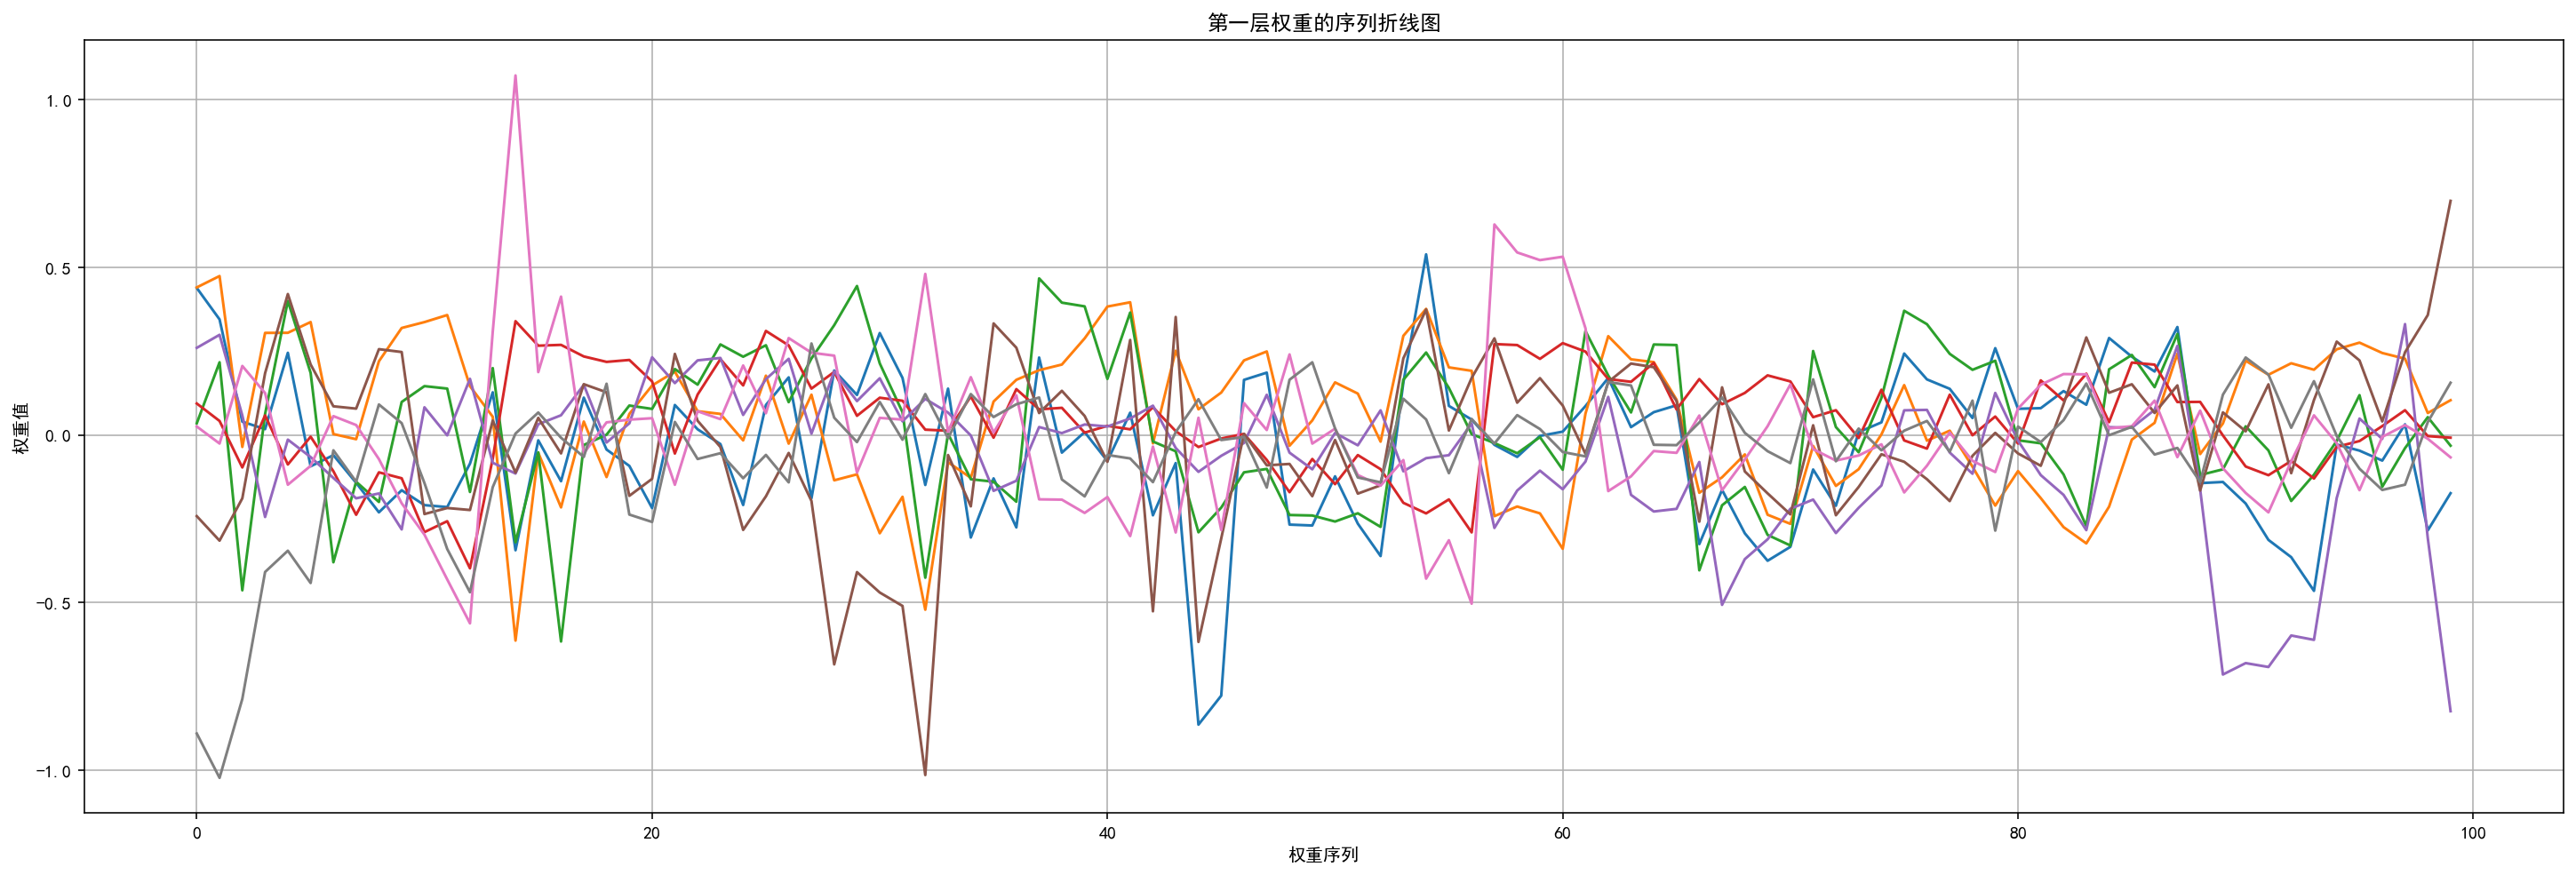

In [9]:
%config InlineBackend.figure_format = 'retina' # 提高图片质量
import matplotlib.pyplot as plt
#####################################
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'
rcParams['axes.unicode_minus'] =False
rcParams['figure.figsize'] = [25, 8]
#####################################

# 将权重转化为numpy数组，并绘制折线图
weights_array = weights.numpy()


for i in range(weights_array.shape[0]):
    plt.plot(weights_array[i])
    
plt.xlabel('权重序列')
plt.ylabel('权重值')
plt.title('第一层权重的序列折线图')
plt.grid(True)
plt.show()

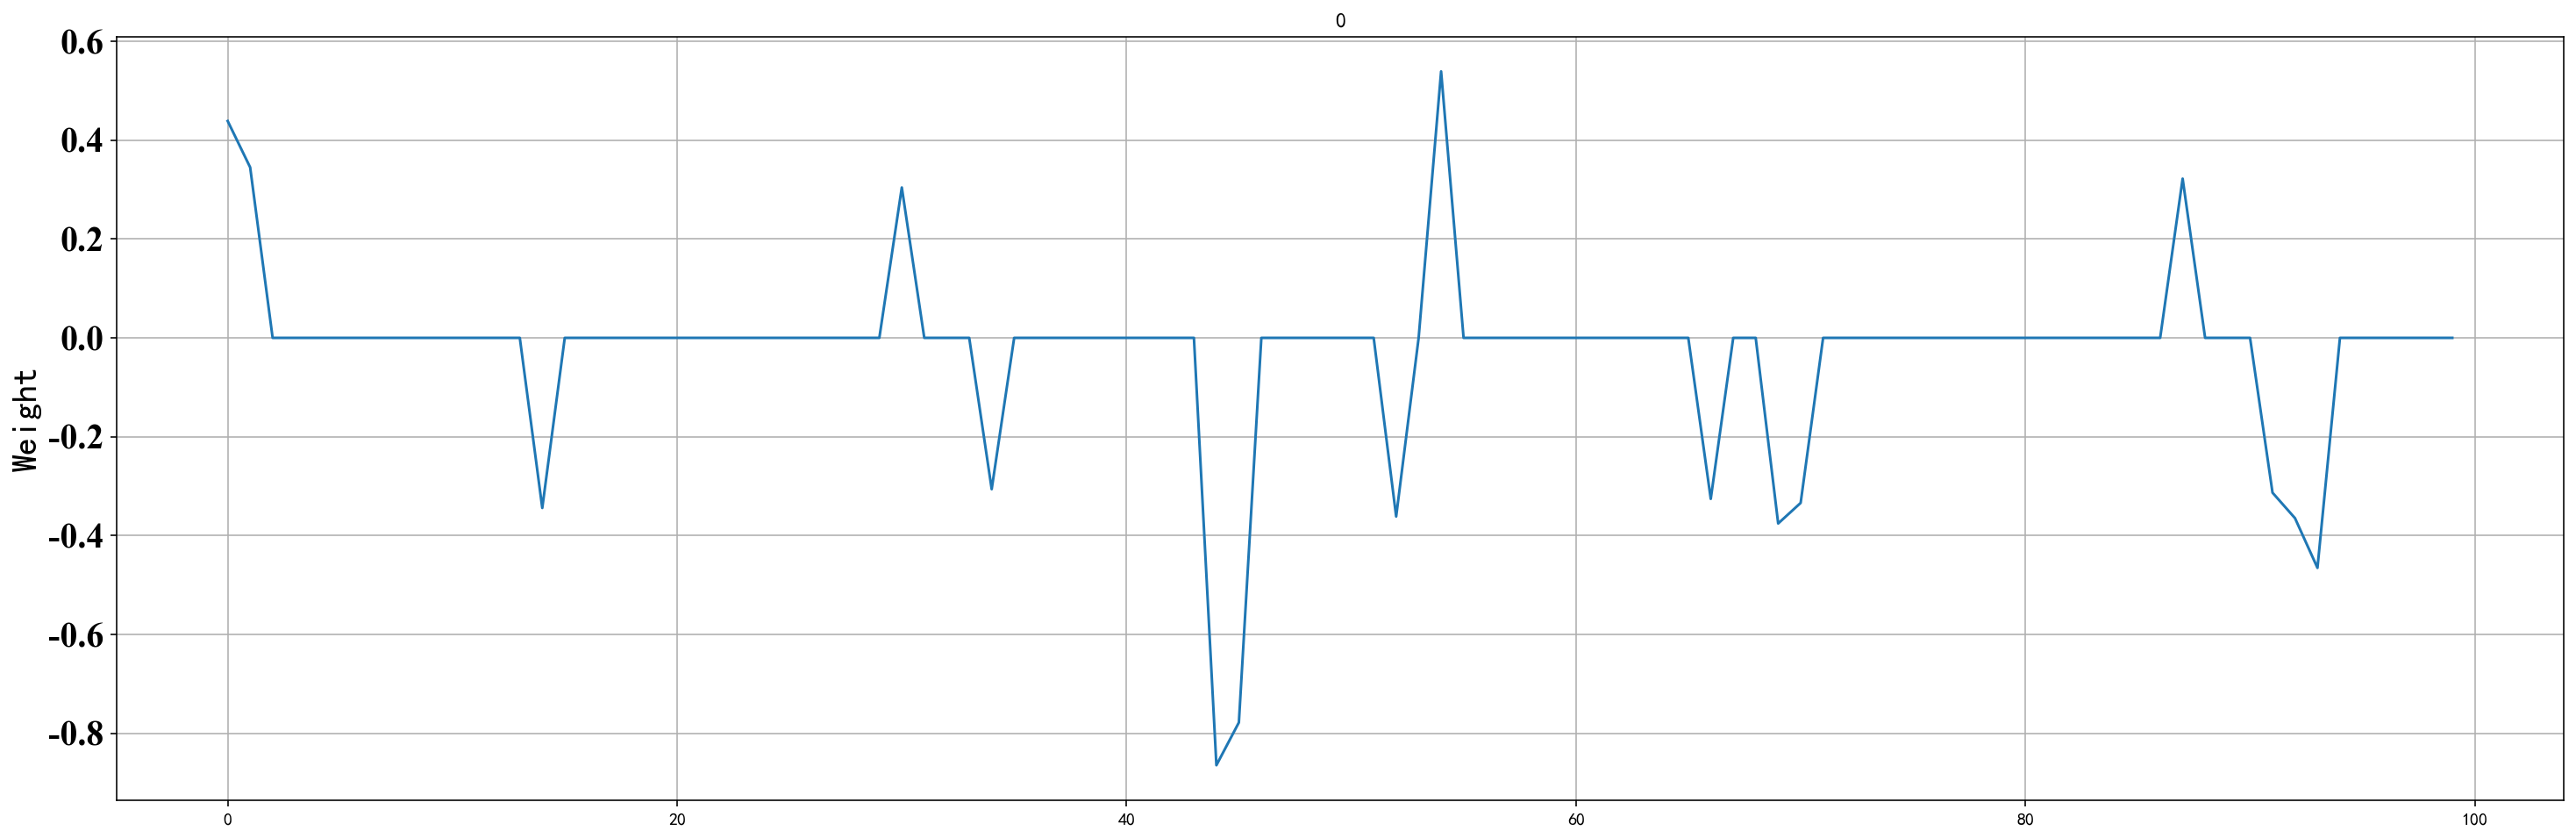

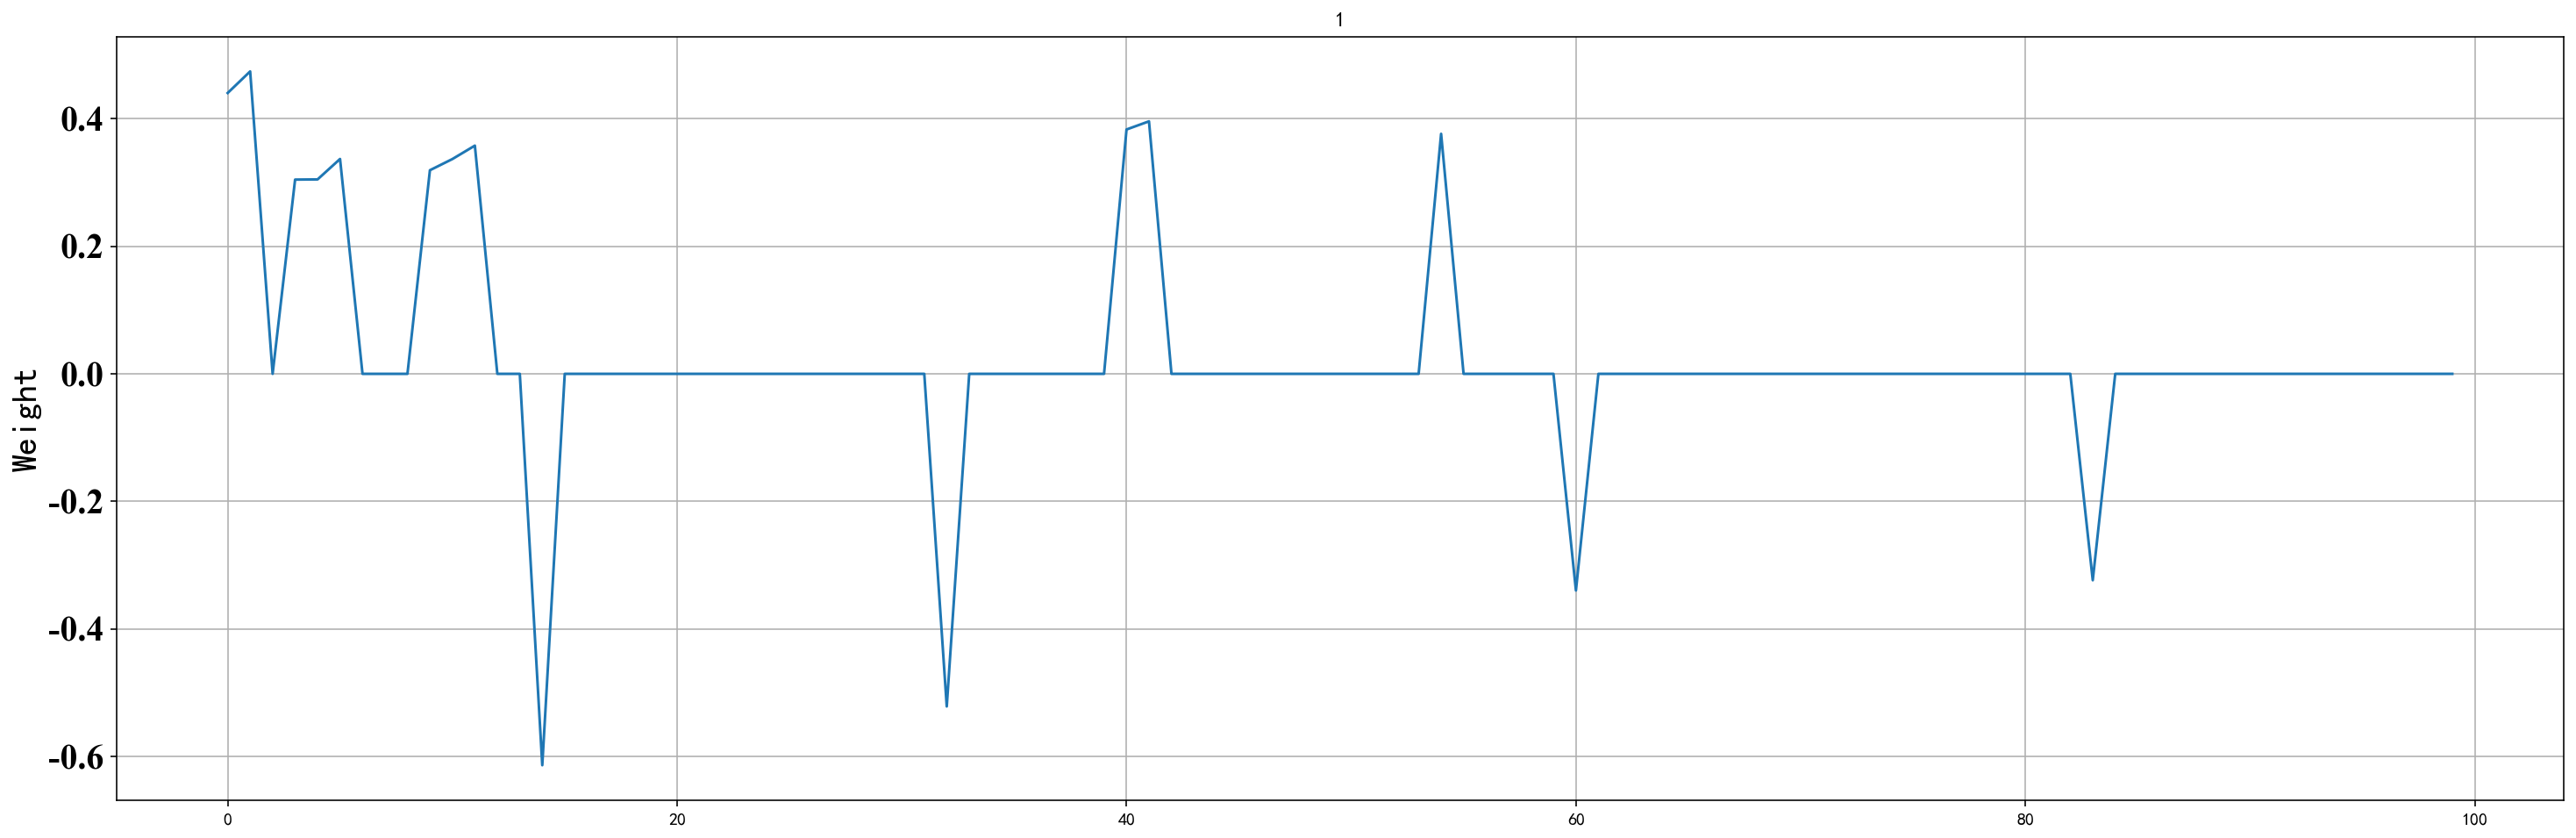

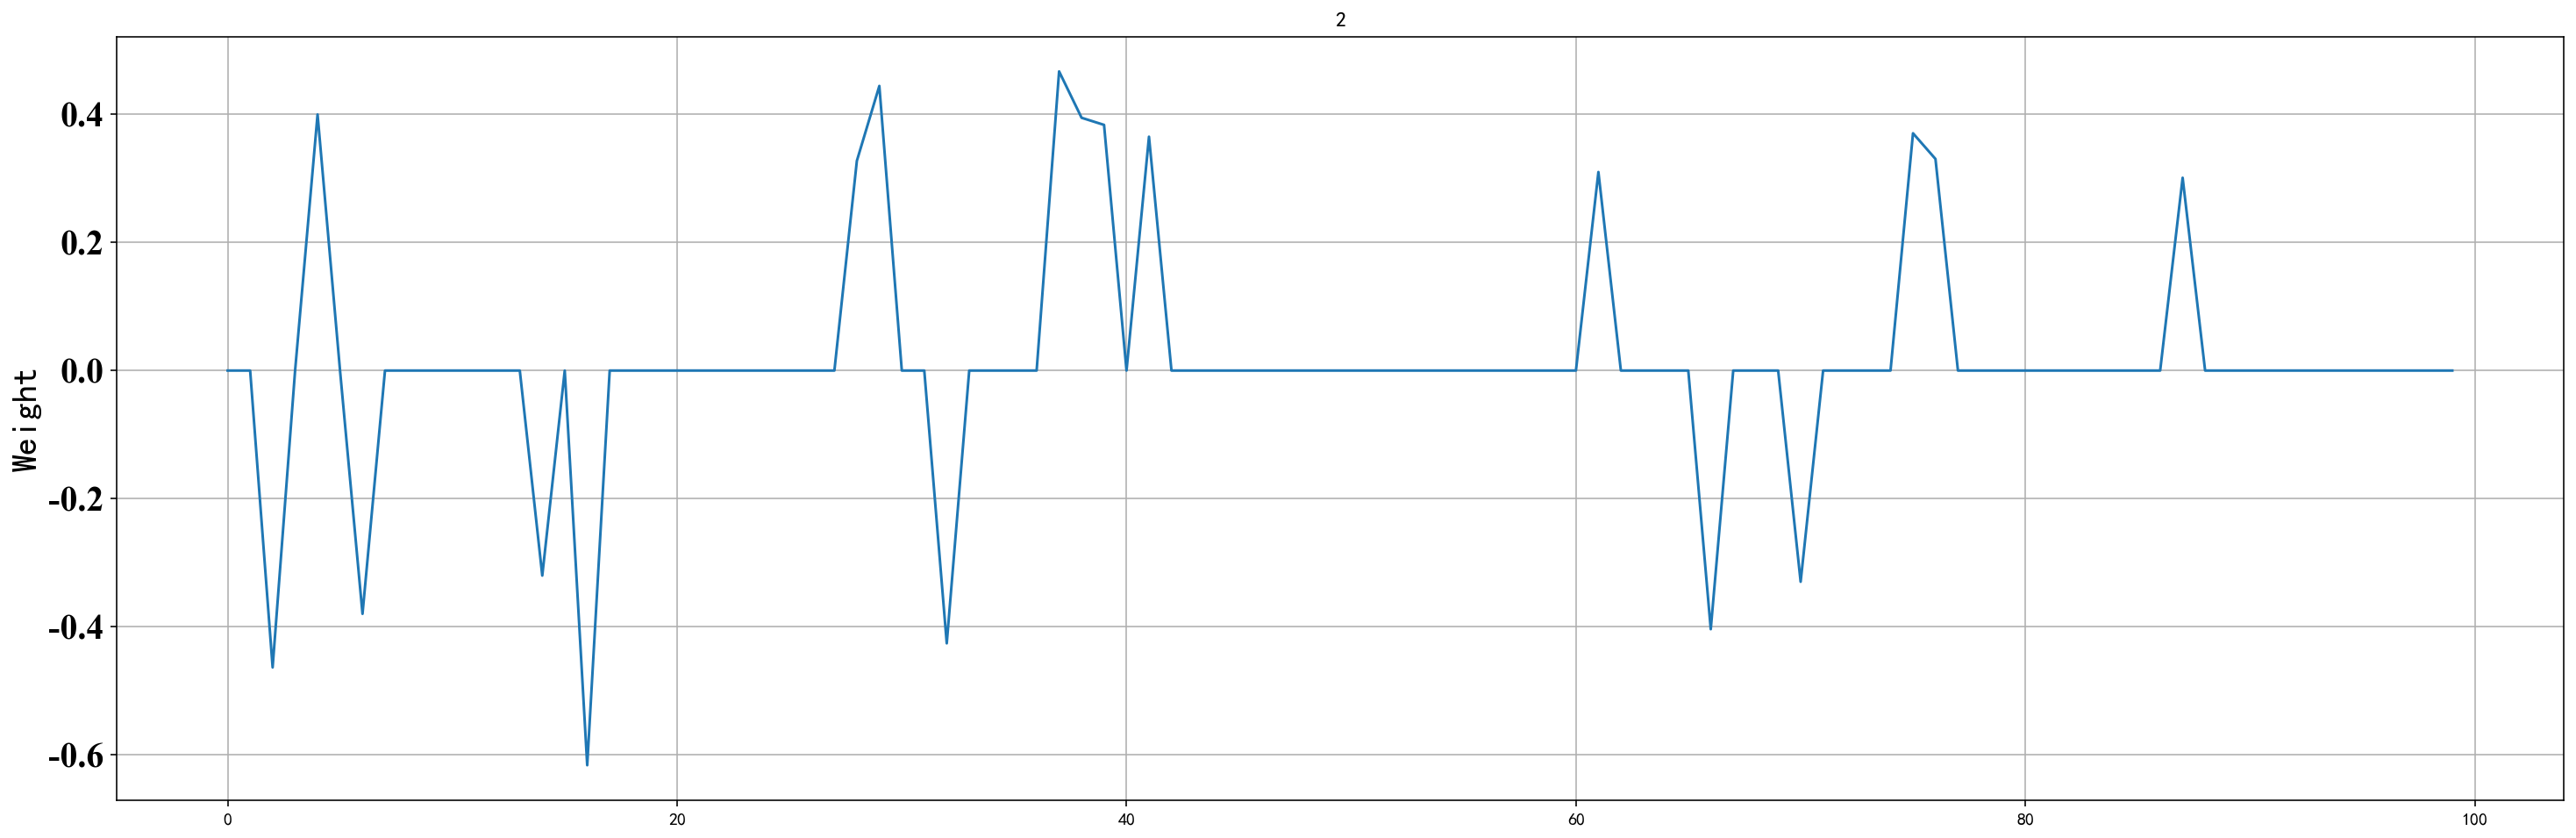

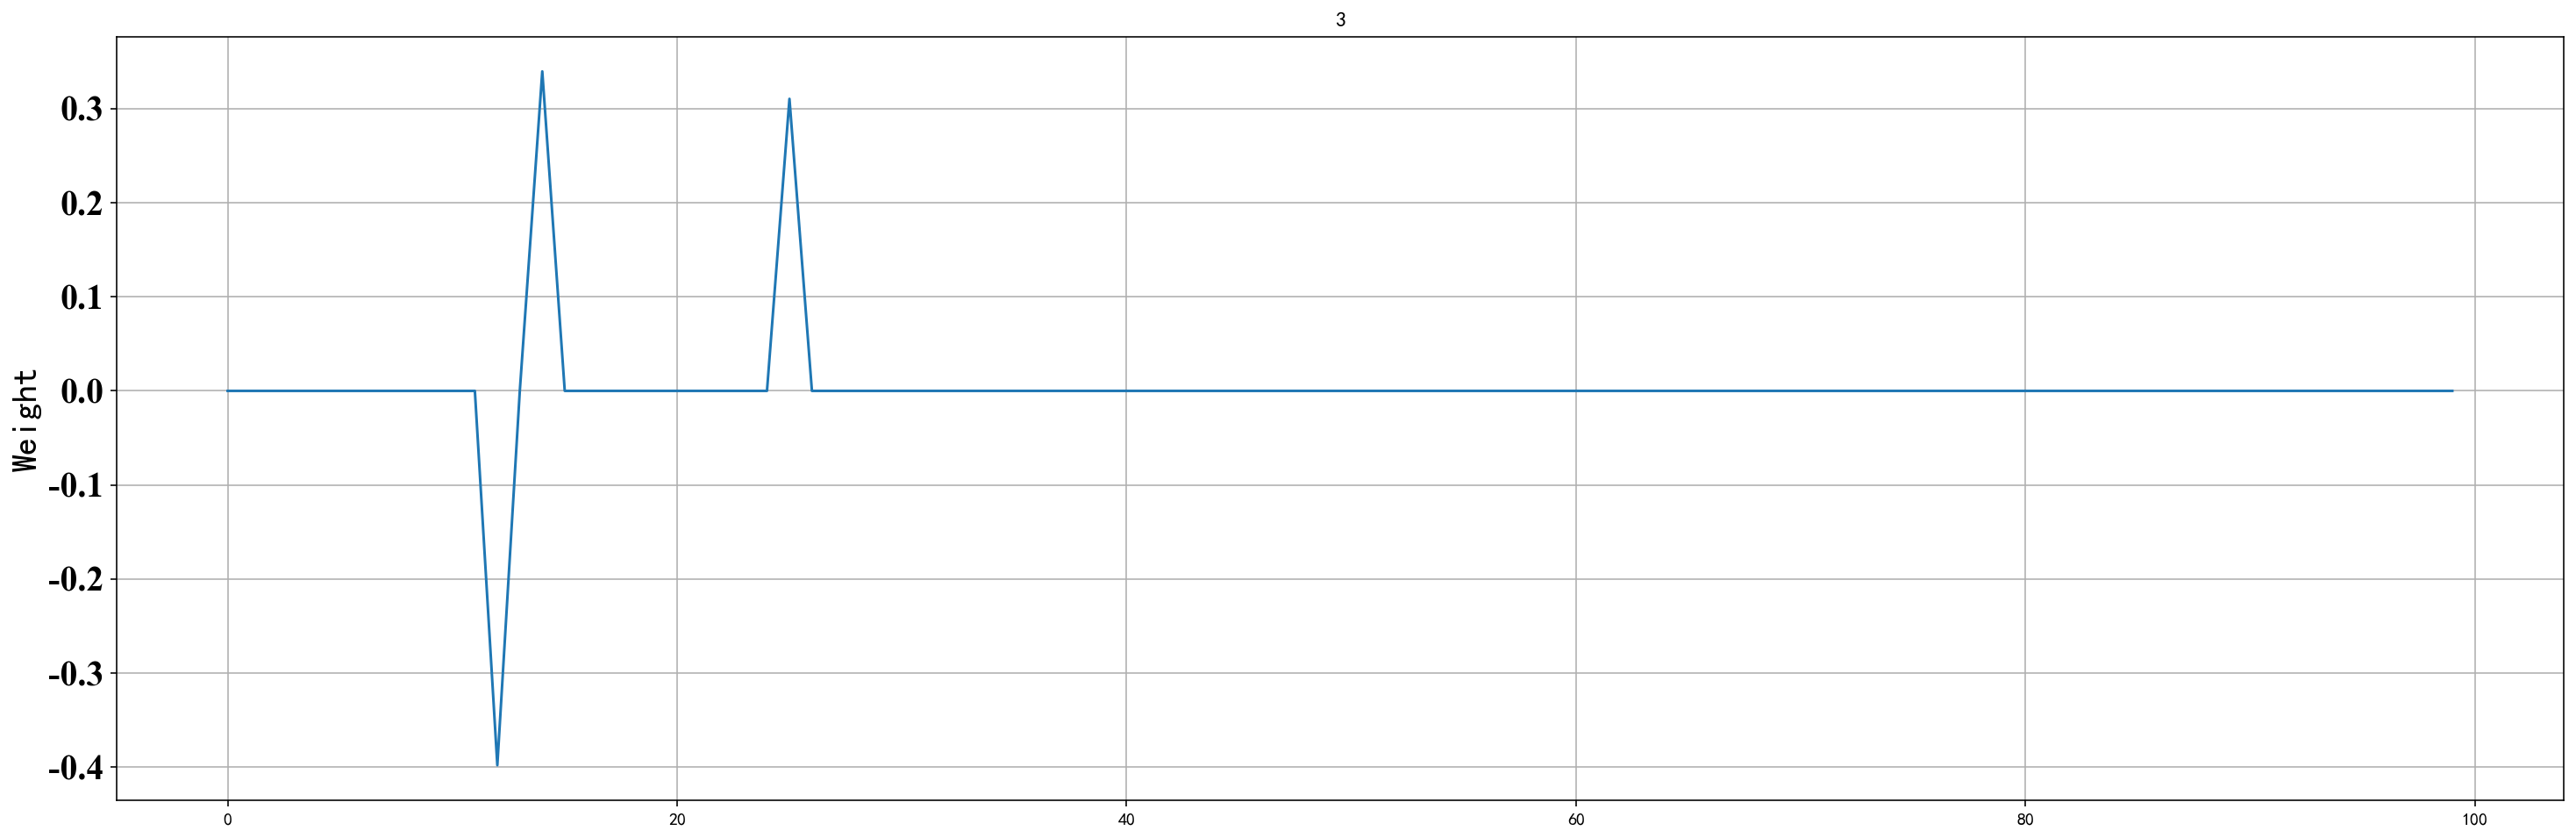

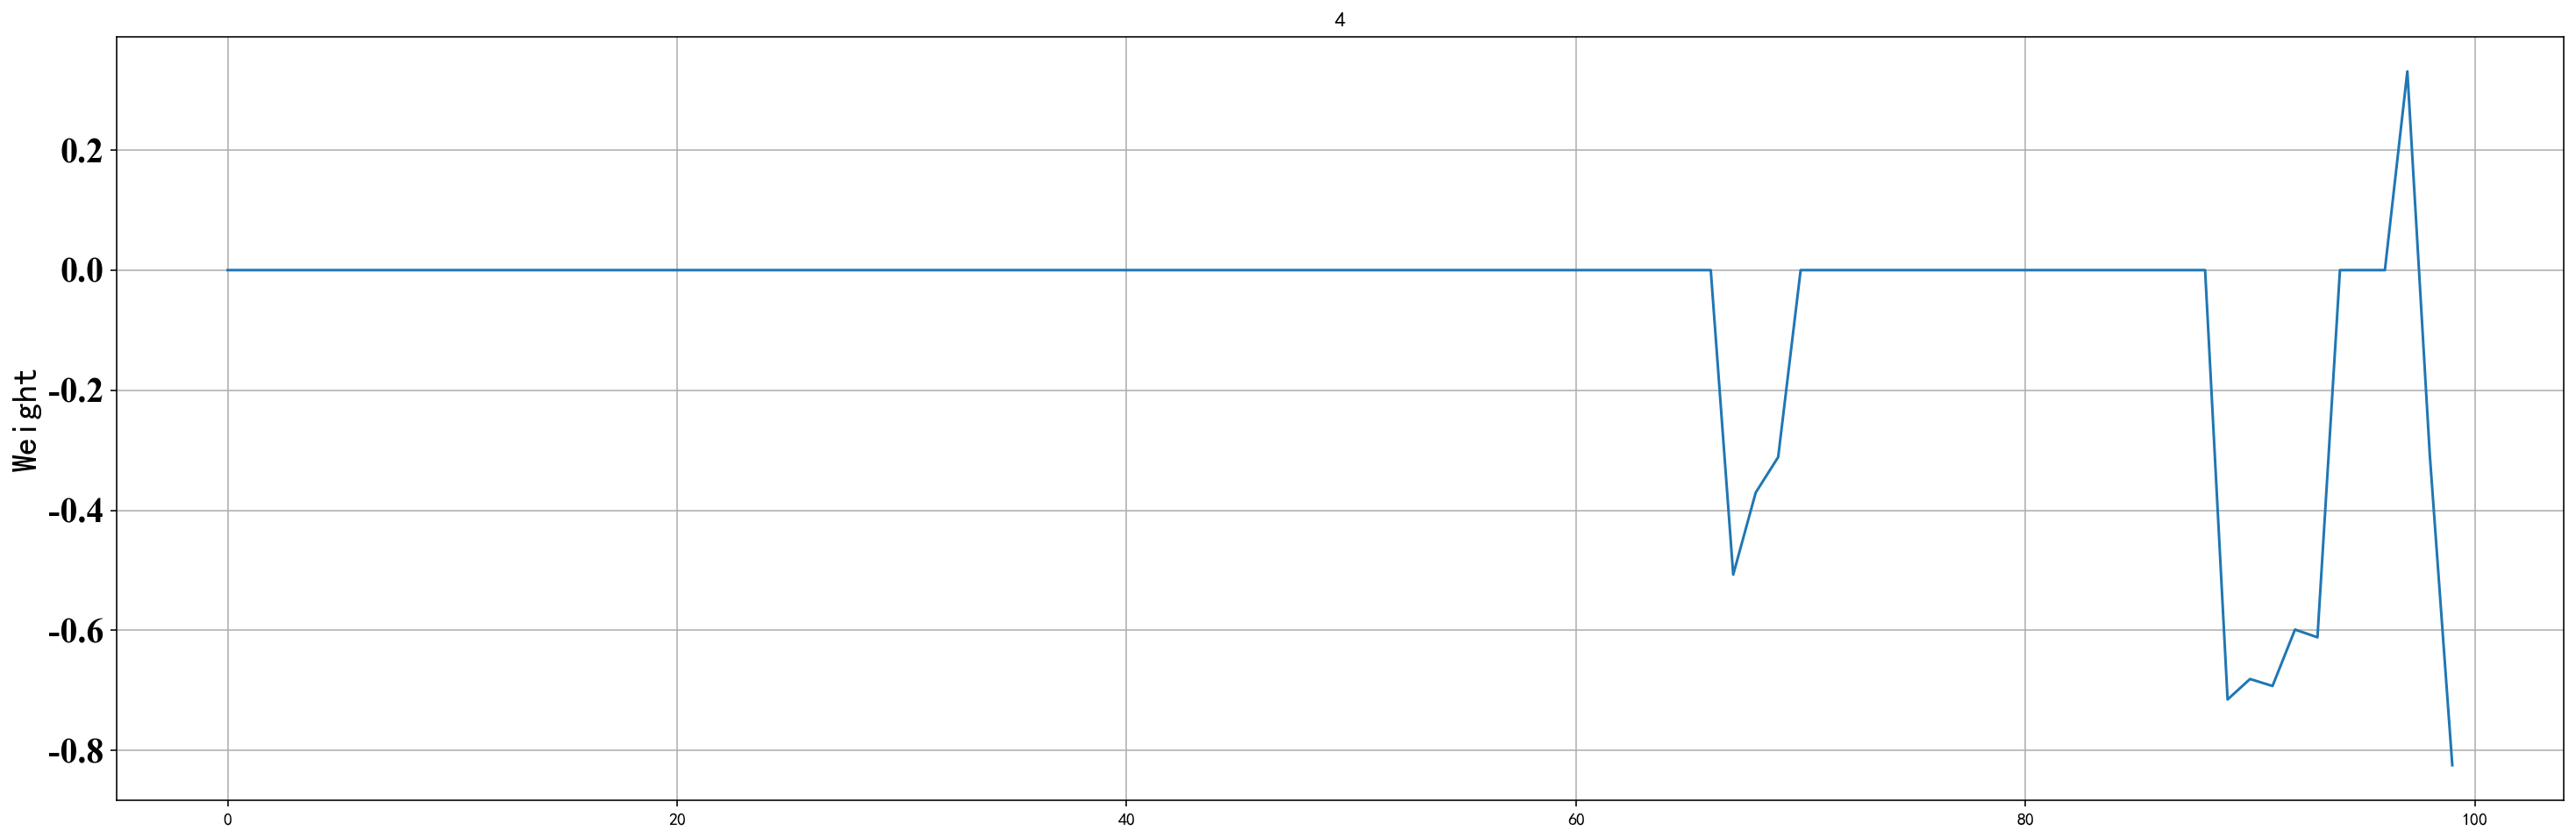

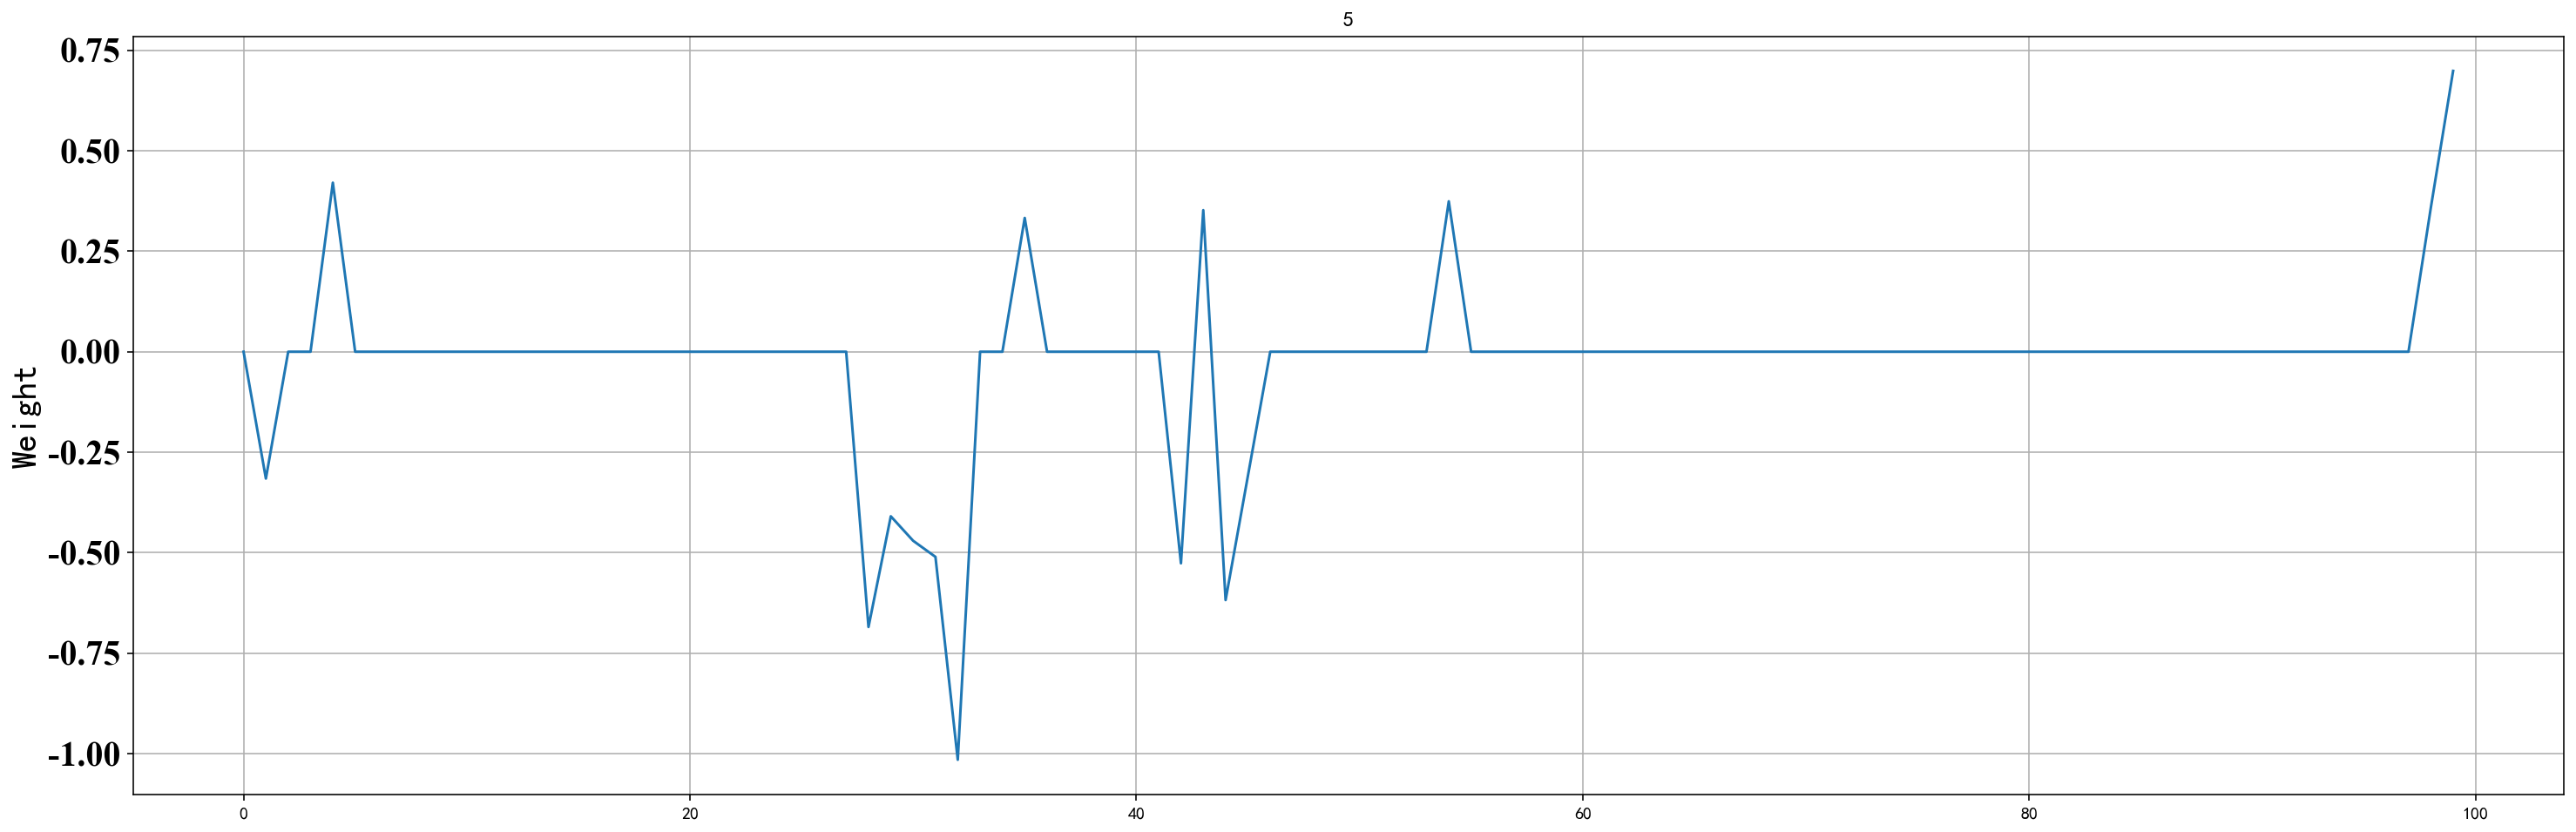

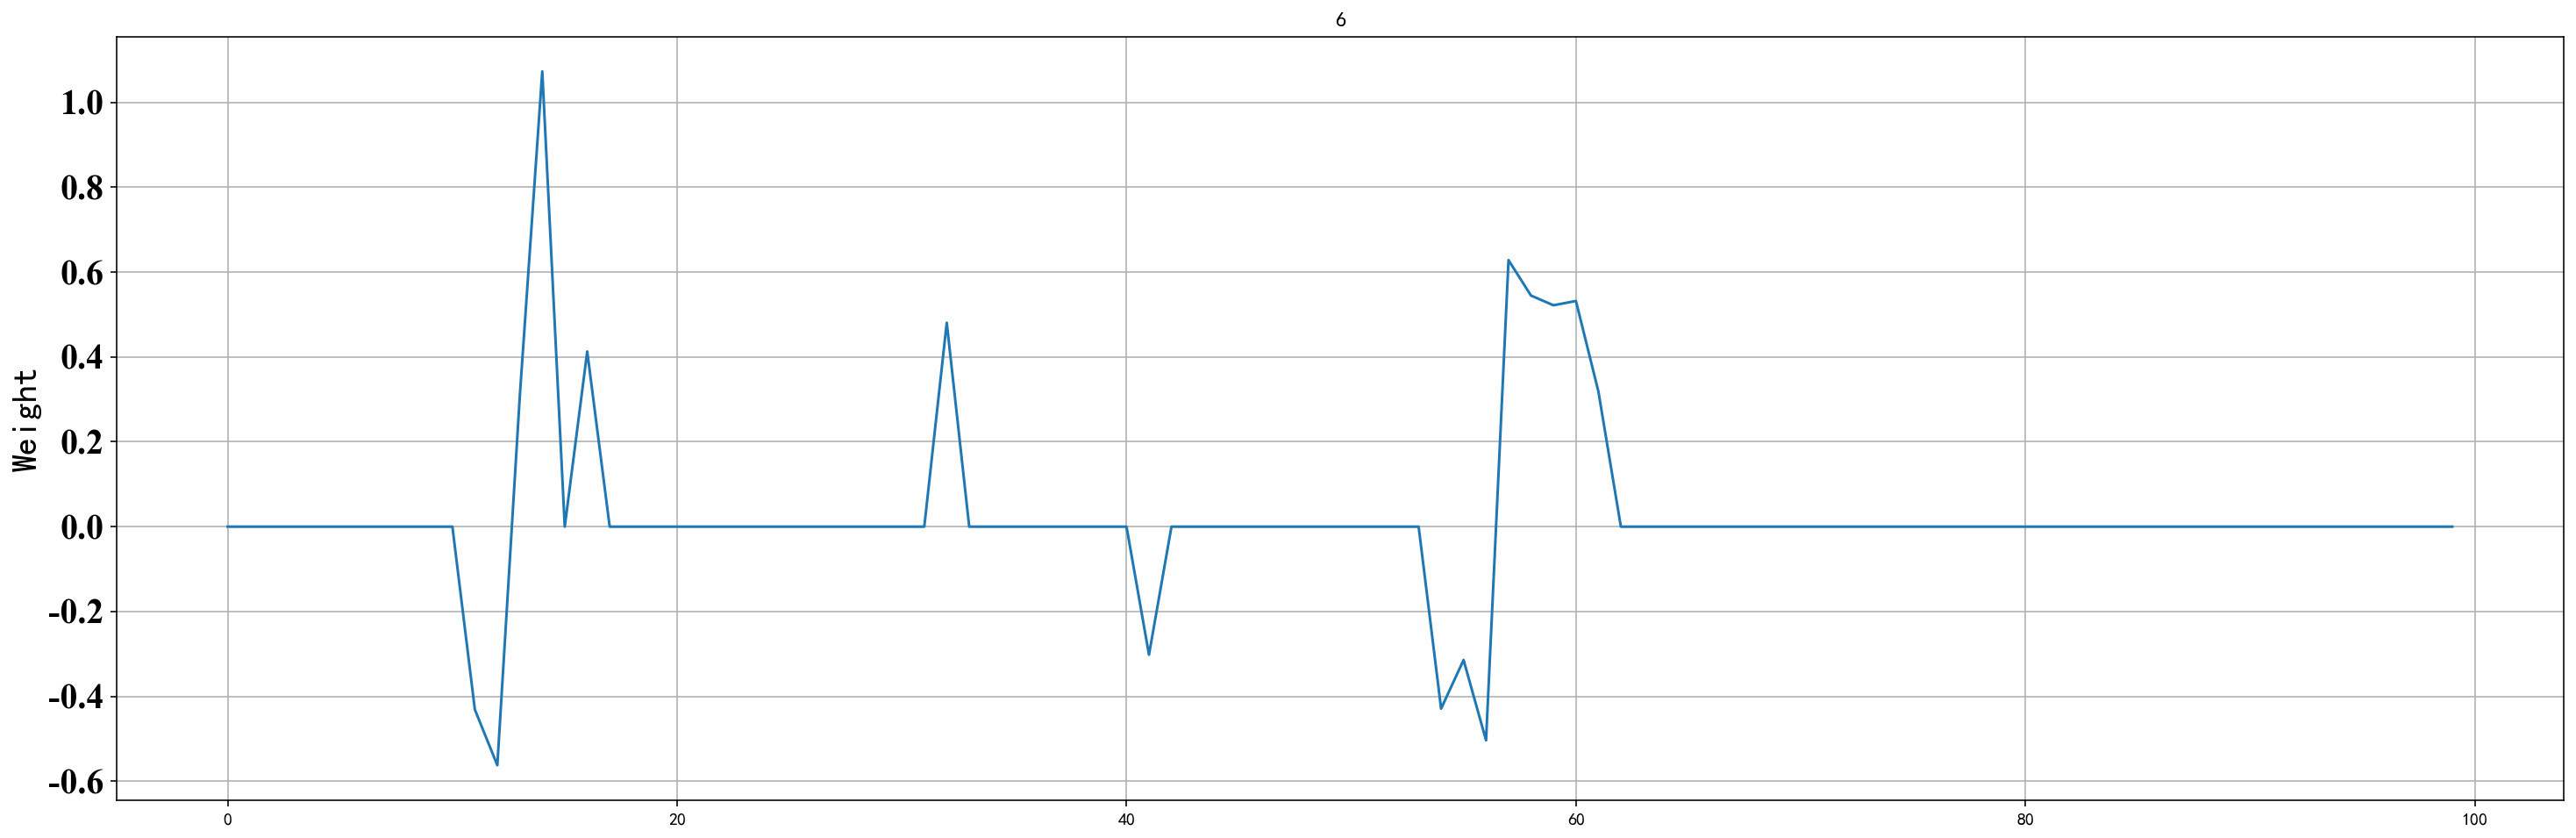

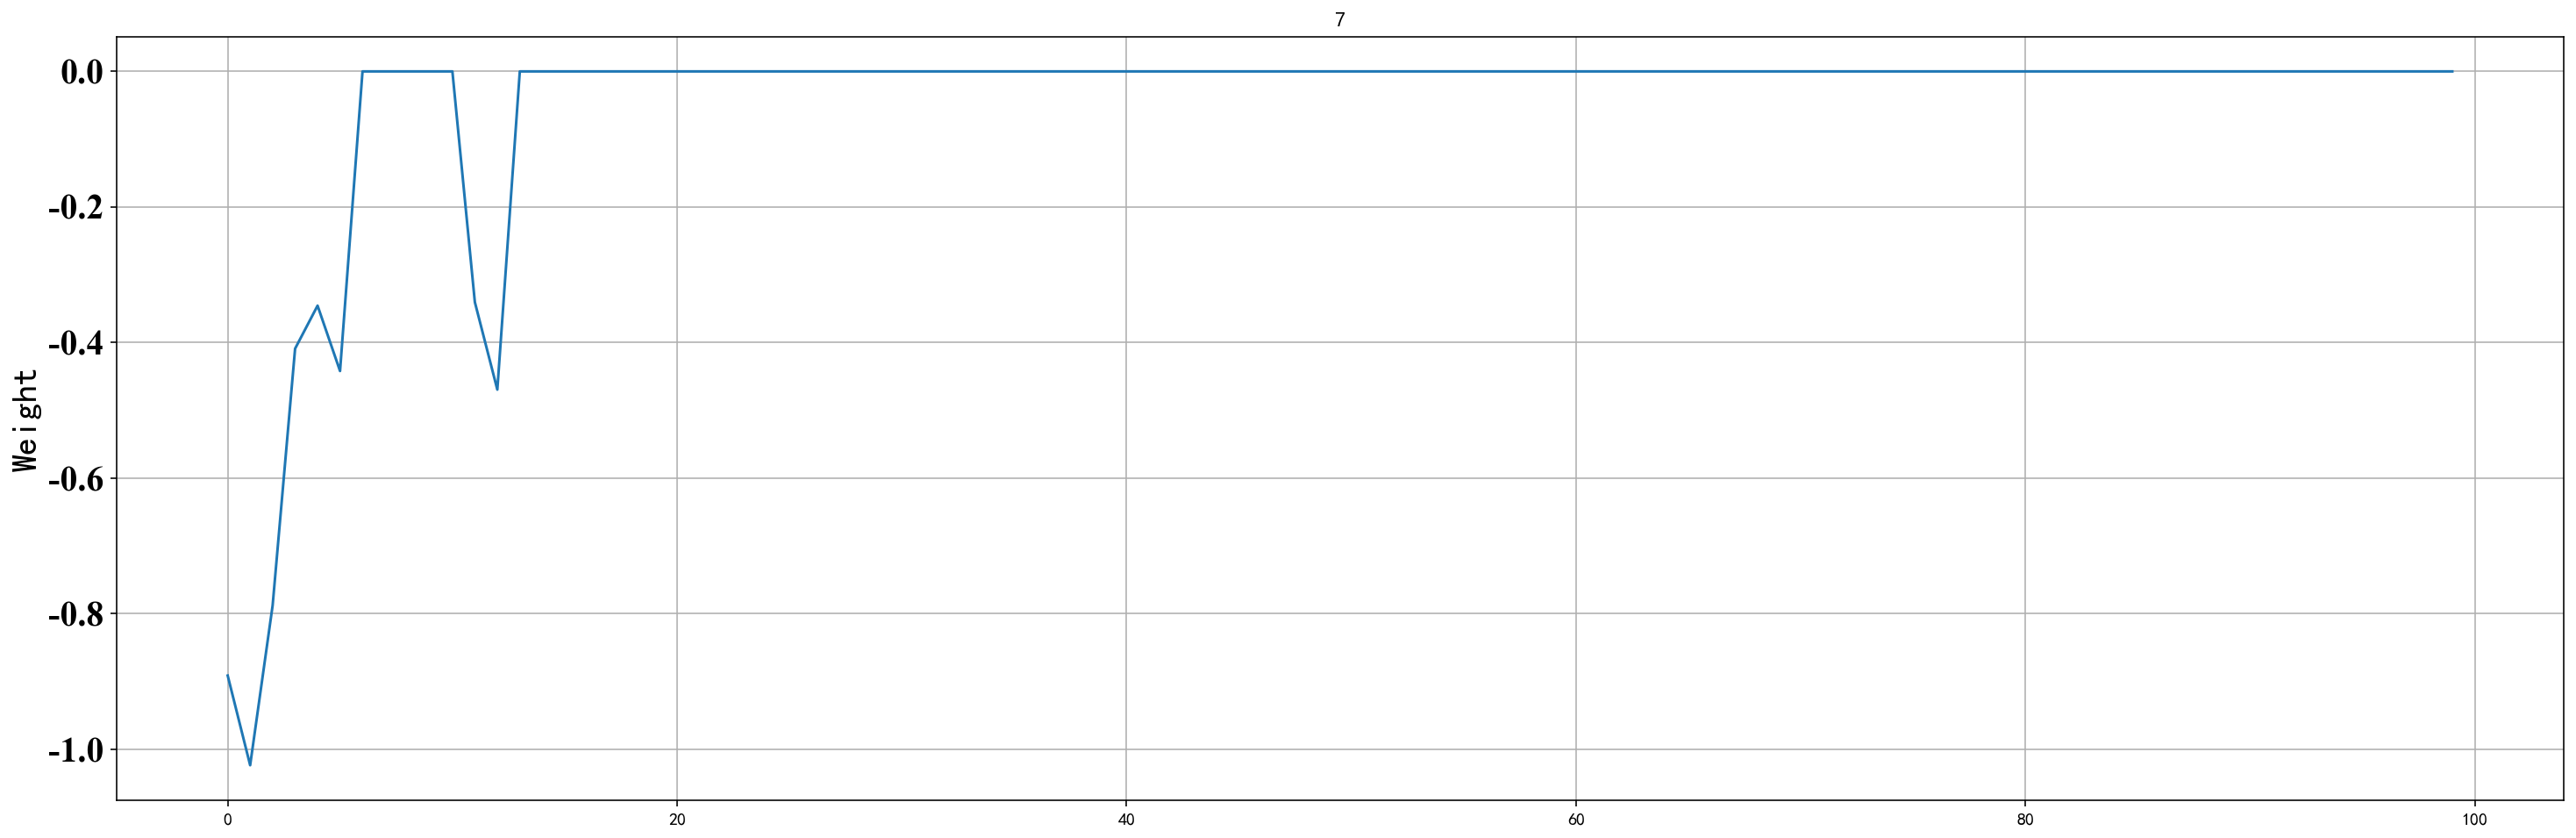

In [10]:
%config InlineBackend.figure_format = 'retina' # 提高图片质量
import matplotlib.pyplot as plt
#####################################
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'
rcParams['axes.unicode_minus'] =False
rcParams['figure.figsize'] = [25, 8]
#####################################
def myplot(array,title,absorb=0.2):
    '''
    :params     array: 序列    absorb: 幅度小于absorb置0
    :returns    图像
    '''
    plt.yticks(fontproperties='Times New Roman', size=20,weight='bold')#设置大小及加粗
    array_2=array.copy()
    array_2[abs(array_2)<absorb]=0
    plt.plot(array_2)    
    # plt.xlabel('Time')
    plt.ylabel('Weight',fontsize=20,fontweight='bold')
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in range(len(weights_array)):
    myplot(weights_array[i],"{}".format(i),0.3)